# Computational Caricaturization of Surfaces

## This is python implementation of "Computational Caricaturization of Surfaces"

In [44]:
import igl
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla

from scipy.sparse import  diags
from scipy.sparse.linalg import spsolve

import open3d as o3d
import ipywidgets as widgets
from open3d.visualization import draw_plotly

from IPython.display import display
# import plotly.graph_objects as go

import trimesh

import torch
import torch.nn.functional as F

# from pytorch3d.utils import ico_sphere
# from pytorch3d.structures import Meshes

from easydict import EasyDict
import matplotlib.pyplot as plt

def rescale(V1 ,V2):
    """rescale V1 to V2"""
    V1mean = (V1.max(0)+V1.min(0))*0.5
    V2mean = (V2.max(0)+V2.min(0))*0.5
    V = (V1-V1mean)/max(V1.max(0)-V1.min(0)) * max(V2.max(0)-V2.min(0)) + V2mean
    return V

def mesh_area(V, F, return_diag=False):
    target_fv = V[F]

    AB = target_fv[:, :, 1] - target_fv[:, :, 0]
    AC = target_fv[:, :, 2] - target_fv[:, :, 0]
    area = 0.5 * np.linalg.norm(np.cross(AB, AC), axis=-1)
    area_diag = np.repeat(area[:, np.newaxis], 3, axis=-1).reshape(-1)
    area = diags(area_diag)
    if return_diag:
        return area, area_diag
    return area


In [36]:
from scipy.sparse.linalg import eigs

V, F = igl.read_triangle_mesh("data/source_restpose_mesh.obj")
L = igl.cotmatrix(V, F)               # cotangent matrix
vals, vecs = eigs(L, k=64)


In [41]:
(vecs @ vals).shape
# vals.shape

(11248,)

In [ ]:


# mesh loading
# V, F = igl.read_triangle_mesh("../m02_model_face.obj")
# V, F = igl.read_triangle_mesh("../000_neutral.obj")
# V, F = igl.read_triangle_mesh("_tmp/m02_model.obj")
V, F = igl.read_triangle_mesh("data/source_restpose_mesh.obj")
# V, F = igl.read_triangle_mesh("../SMPL_TPose_00.obj")

V = V.astype(np.float64)
F = F.astype(np.int32)

# cotangent & mass matrix
C = igl.cotmatrix(V, F)               # cotangent matrix
M = igl.massmatrix(V, F, igl.MASSMATRIX_TYPE_VORONOI)

D = igl.doublearea(V, F) * 0.5        # |K| : area of each face
D = np.abs(D)
D = np.hstack([D, D, D])

# D_ = sp.diags(D)

# S_A, D = mesh_area(V, F, return_diag=True)

# print(M.shape)
# print(D.shape)
# M = np.hstack([M, M, M])
# print(M.shape)
# GC = igl.gaussian_curvature(V, F)     # shape: (nV,)



# gradient
G = igl.grad(V, F)                    # shape: (3*T, nV) ::: T = F.shape[0]
print(G.shape)

# edge-based operators
# L = G.T @ S_A @ G                           # Approx. Laplacian
L = G.T @ G                           # Approx. Laplacian


def mesh_smooth(V, F, values, tau=0.001):
    # Mesh smoothing with libigl
    l = igl.cotmatrix(V, F)  # laplace-beltrami operator in libigl
    m = igl.massmatrix(V, F, igl.MASSMATRIX_TYPE_BARYCENTRIC) # mass matrix in libigl
    s = m - tau * l
    return spsolve(s, m @ values)

# carve out the deformation
def compute_caricature(gamma=0.25):
    # shape difference operator: target exaggeration
    K = np.power(D, gamma)
    # K = np.power(M, gamma)
    # E = int(V.shape[0]/2)
    # E = 6706
    # E = 9409
    # K[:E] = 0
    # K[E:] = 0
    K = sp.diags(K)
    
    # exaggerate shape difference
    b = L @ V                          # nV x 3
    
    # A = G.T @ ((K @ S_A) @ G)                  # Laplacian approx (nV x nV)
    A = G.T @ (K @ G)                  # Laplacian approx (nV x nV)
    
    V_new = spla.spsolve(A, b)
    V_new = V_new.reshape(-1,3)
    
    return V_new

def get_new_mesh(V_new):
    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(V_new)
    mesh.triangles = o3d.utility.Vector3iVector(F)
    mesh.compute_vertex_normals()
    return mesh

# ipywidgets slider
gamma_slider = widgets.FloatSlider(value=0.2, min=0.0, max=1.0, step=0.05, description='Gamma')
output = widgets.Output()

# update drawing
def update_plot(gamma):
    output.clear_output(wait=True)
    with output:
        if gamma > 0:
            V_new = compute_caricature(gamma)
            m = get_new_mesh(V_new)
            draw_plotly([m],width=600, height=600)
        else:
            m = get_new_mesh(V)
            draw_plotly([m],width=600, height=600)

# ipywidgets interaction
widgets.interact(update_plot, gamma=gamma_slider)
display(output)

(66864, 11248)


interactive(children=(FloatSlider(value=0.2, description='Gamma', max=1.0, step=0.05), Output()), _dom_classes…

Output()

## Save mesh

In [8]:
V_new = compute_caricature(gamma=.2)
V_new = rescale(V_new, V)
igl.write_triangle_mesh("data/m02_deformed-0.2.obj", V_new, F)

V_new = compute_caricature(gamma=.45)
V_new = rescale(V_new, V)
igl.write_triangle_mesh("data/m02_deformed-0.45.obj", V_new, F)

(66864, 66864)
(66864, 66864)


# Expression cloning

In [196]:
def get_vertex_to_face_map(V, F):
    """
    For each vertex, returns a list of face indices it belongs to.

    Args:
        V (np.ndarray): Vertices array of shape (n, 3)
        F (np.ndarray): Faces array of shape (m, 3)

    Returns:
        vertex_face_map (list of lists): vertex_face_map[i] contains the list of face indices that vertex i belongs to
    """
    num_vertices = V.shape[0]
    vertex_face_map = [[] for _ in range(num_vertices)]

    for face_idx, face in enumerate(F):
        for vertex_idx in face:
            vertex_face_map[vertex_idx].append(face_idx)

    return vertex_face_map

def get_TBN_foreach_vertex(V, F):
    """
    Get TBN matrix for each vertex

    Args:
        V (np.ndarray): vertices (N, 3)
        F (np.ndarray): faces / trianlges (M, 3)

    Returns:
        np.ndarray: matrix (N, 3, 3)
        [
            [Tx, Ty, Tz],
            [Bx, By, Bz],
            [Nx, Ny, Nz],
        ]
    """
    Vn = igl.per_vertex_normals(V, F)
    
    al = igl.adjacency_list(F) # all neighbors
    nb = [nbrs[0] for nbrs in al] # select one

    Vt_nb = V[nb] - V
    Vt_nb = Vt_nb/np.linalg.norm(Vt_nb, axis=1)[:,None]

    # project
    _Vt = np.sum(Vt_nb * Vn, axis=1, keepdims=True)
        
    Vt = (Vt_nb - _Vt * Vn)
    Vt = Vt/np.linalg.norm(Vt, axis=1)[:,None]
    
    Vb = np.cross(Vn, Vt)
    Vb = Vb/np.linalg.norm(Vb, axis=1)[:,None]
    
    return np.concatenate([
        Vt[:,None], 
        Vb[:,None],
        Vn[:,None], 
    ], axis=1)

def rescale(V1 ,V2):
    """rescale V1 to V2"""
    V1mean = (V1.max(0)+V1.min(0))*0.5
    V2mean = (V2.max(0)+V2.min(0))*0.5
    V = (V1-V1mean)/max(V1.max(0)-V1.min(0)) * max(V2.max(0)-V2.min(0)) + V2mean
    return V

def get_TriangleArea_foreach_vertex(V,F):
    """
    Returns (V,)
    """
    DArea = igl.doublearea(V, F) * 0.5
    print(DArea.shape)

    V2F = get_vertex_to_face_map(V,F)
    VArea = []
    for v2f in V2F:
        VArea.append(np.sum(DArea[v2f])/len(v2f))
    VArea = np.array(VArea)
    return VArea

def get_scale_foreach_vertex(V,F):
    """
    Returns (V, 3)
    """
    Vxyz = []
    for vf in V[F]:
        Vxyz.append(vf.max(0)-vf.min(0))
    Vxyz = np.array(Vxyz)
    
    V2F = get_vertex_to_face_map(V,F)
    Vscale = []
    for v2f in V2F:
        Vscale.append(np.mean(Vxyz[v2f],axis=0))
    Vscale = np.array(Vscale)
    return Vscale

In [185]:
V[[1,2]].max(0)-V[[1,2]].min(0)

array([2.180000e-06, 2.026929e-02, 2.558064e-02])

## create mesh set

In [ ]:
V, F = igl.read_triangle_mesh("../m02_model.obj")
# Vn = igl.per_vertex_normals(V, F)
# F

newV = compute_caricature(gamma=.2)
newV = rescale(newV ,V)
# Vn_new = igl.per_vertex_normals(V_new, F)

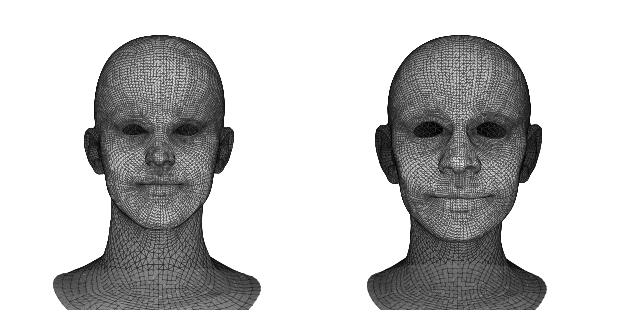

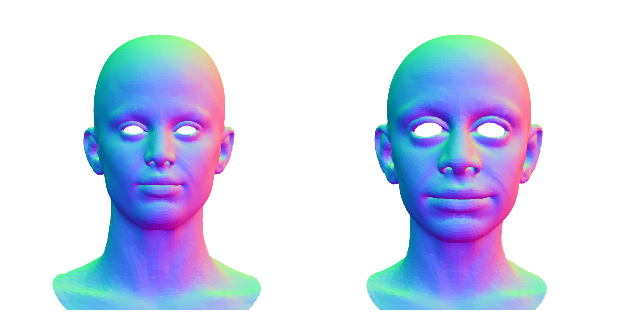

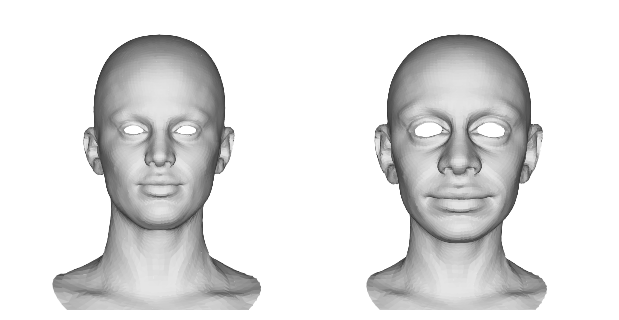

In [166]:
from matplotrender import *
# figure size
SIZE = 3
mesh_scale = 0.6
# mesh that you wanna render
FRAME=150
v_list=[ V, newV ]
v_list=[ v*mesh_scale for v in v_list]
f_list=[ F ]*len(v_list)

# xyz Euler angle to rotate the mesh
rot_list=[ [0,0,0] ]*len(v_list)

plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE)
plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='normal')
plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='shade')

In [137]:
# print(V.min(), V.max())
# print(newV.min(), newV.max())
# renewV = rescale(newV ,V)
# print(renewV.min(), renewV.max())

-1.81234658 1.3834517
-8.836712482336264 4.014717728691488
-1.59789914 1.59789914


## Get local coordinate system via TBN matrix

In [167]:
V_TBN = get_TBN_foreach_vertex(V, F)
newV_TBN = get_TBN_foreach_vertex(newV, F)

In [192]:
Varea[0].shape

(6,)

In [213]:
if True:
    Varea = get_TriangleArea_foreach_vertex(V,F)
    newVarea = get_TriangleArea_foreach_vertex(newV,F)
    newS = newVarea/Varea
    newS = np.eye(3)[None] * newS[:,None,None]
else:
    Varea = get_scale_foreach_vertex(V,F)
    newVarea = get_scale_foreach_vertex(newV,F)
    newS = newVarea/Varea
    newS = np.eye(3)[None, :, :] * newS[:, :, None]

(22288,)
(22288,)


In [123]:
motions = np.load(r'_tmp\040.npy')
print(motions.shape)

(219, 11248, 3)


In [214]:
# MAT = VArea*np.einsum('bcn, bnk->bck', V_TBN.transpose(0,2,1), newV_TBN)
MAT = newS*np.einsum('bcn, bnk->bck', newV_TBN, V_TBN.transpose(0,2,1))

In [215]:
displacements = motions - V[None]
print(displacements.shape, displacements.max())

new_displacements = np.einsum('vcn, bvn->bvc', MAT, displacements)
print(new_displacements.shape, new_displacements.max())

(219, 11248, 3) 0.1140987559386768
(219, 11248, 3) 0.7125912281212904


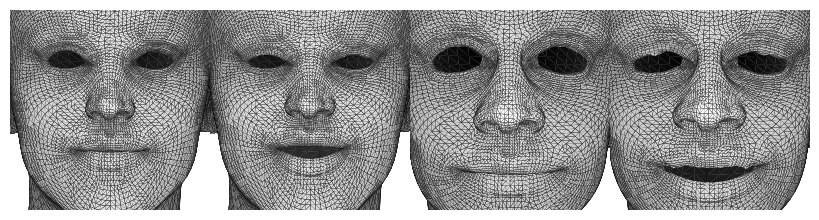

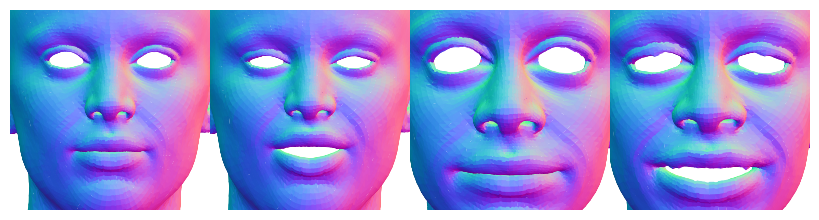

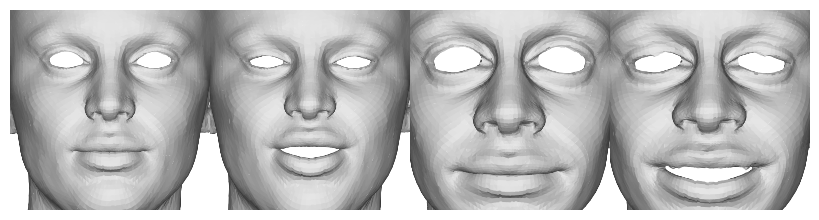

In [209]:
from matplotrender import *
# import trimesh
# mesh = trimesh.load('your_mesh_file.obj')
# print(mesh.vertices.shape)

# figure size
SIZE = 2

# mesh that you wanna render
FRAME=150
v_list=[ V, displacements[FRAME]+V, newV, new_displacements[FRAME]+newV ]
v_list=[v*1.5 for v in v_list]
f_list=[ F ]*len(v_list)

# xyz Euler angle to rotate the mesh
rot_list=[ [0,0,0] ]*len(v_list)

plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE)
plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='normal')
plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='shade')

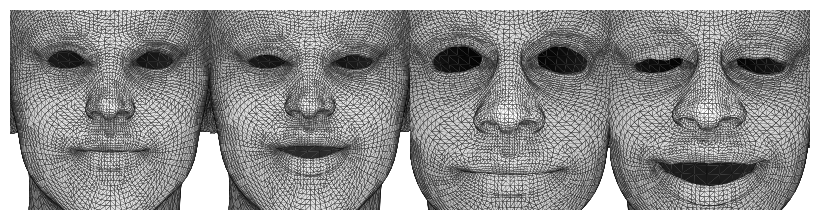

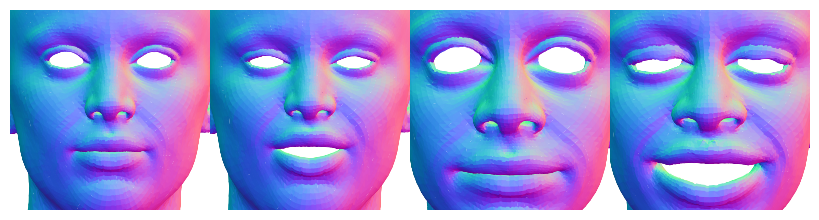

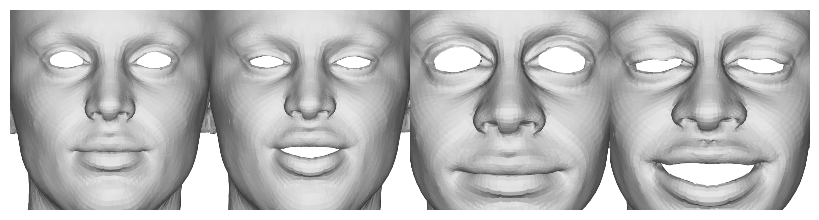

In [216]:
from matplotrender import *
# import trimesh
# mesh = trimesh.load('your_mesh_file.obj')
# print(mesh.vertices.shape)

# figure size
SIZE = 2

# mesh that you wanna render
FRAME=150
v_list=[ V, displacements[FRAME]+V, newV, new_displacements[FRAME]+newV ]
v_list=[v*1.5 for v in v_list]
f_list=[ F ]*len(v_list)

# xyz Euler angle to rotate the mesh
rot_list=[ [0,0,0] ]*len(v_list)

plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE)
plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='normal')
plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='shade')

In [77]:
print(Vt[0], np.linalg.norm(Vt[0]))
print(Vn[0], np.linalg.norm(Vn[0]))

np.dot(Vt[0], Vn[0].T)

[-0.01133757  0.99424462 -0.10653209] 1.0
[-0.04685715  0.10589364  0.99327284] 1.0


-4.163336342344337e-17

In [73]:
Vb = np.cross(Vn, Vt)
Vb = Vb/np.linalg.norm(Vb, axis=1)[:,None]

In [55]:
np.linalg.norm(Vb, axis=1)[:,None]

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

In [75]:
print(Vt[0], np.linalg.norm(Vt[0]))
print(Vn[0], np.linalg.norm(Vn[0]))
print(Vb[0], np.linalg.norm(Vb[0]))

print(np.dot(Vt[0], Vn[0].T))
print(np.dot(Vt[0], Vb[0].T))
print(np.dot(Vn[0], Vb[0].T))

[-0.01133757  0.99424462 -0.10653209] 1.0
[-0.04685715  0.10589364  0.99327284] 1.0
[-0.99883726 -0.01625309 -0.04538689] 1.0
-4.163336342344337e-17
-2.6020852139652106e-18
0.0


In [16]:
A = igl.adjacency_matrix(F)
print(F)
print(np.argmax(A.todense(), axis=1))

[[  873    11   870]
 [  870    11  1492]
 [   17  1189  1190]
 ...
 [11154 11039 11040]
 [11155 11043 11039]
 [11156  9679 11043]]
[[    2]
 [    3]
 [    0]
 ...
 [11014]
 [11236]
 [10957]]


In [ ]:

"""
we skip the correspondence selection process as both mesh shares same mesh structure
TODO
    - [ ] local coordination (source -> deformed source)
    - [ ] local rotation
    - [ ] local scaling
"""


In [27]:
asd = trimesh.load(r"D:\test\Mesh-editing-with-pyopengl\_tmp\016039.obj",process=False, maintain_order=True)

c:\Users\SihunCha\.conda\envs\pytorch3d\lib\site-packages\numpy\lib\nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


In [31]:
print(asd.vertices.shape, asd.faces.shape)

(7306, 3) (10936, 3)


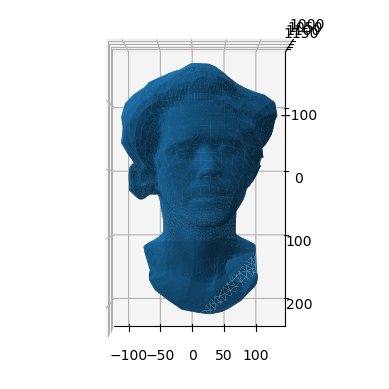

In [ ]:
# asd.show()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.view_init(azim=-90, elev=-90)
ax.set_box_aspect((np.ptp(asd.vertices[:, 0]),np.ptp(asd.vertices[:, 1]),np.ptp(asd.vertices[:, 2])))
ax.plot_trisurf(asd.vertices[:, 0], asd.vertices[:,1], asd.vertices[:,2], triangles=asd.faces)

In [29]:
qwe = trimesh.load(r"D:\test\Mesh-editing-with-pyopengl\_tmp\test.obj",process=False, maintain_order=True)

In [32]:
print(qwe.vertices.shape, qwe.faces.shape)

(6788, 3) (10936, 3)


In [38]:
asd = load_obj_mesh(r"D:\test\Mesh-editing-with-pyopengl\_tmp\016039.obj")
qwe = load_obj_mesh(r"D:\test\Mesh-editing-with-pyopengl\_tmp\test.obj")

In [41]:
print(asd.v.shape, asd.f.shape)
print(qwe.v.shape, asd.f.shape)

print(asd.vt.shape, asd.ft.shape)
print(qwe.vt.shape, asd.ft.shape)

(7306, 3) (10936, 3)
(6788, 3) (10936, 3)
(32808, 2) (10936, 3)
(6788, 2) (10936, 3)
